## DeepCell - Imaris - Segmentation & Tracking Comparision

### Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio
import tifffile as tiff 
import pickle
from pathlib import Path
from skimage import io
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import re

c:\Projects\TAU\DL-Workshop\Git Folder\Env\dl_work_mod\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Functions

In [3]:
def result_csv_no_crop_to_table(table_path,start):
    df_deep = pd.read_csv(r'C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Results\Tracking_no_crop\Results_D2_1_start_3_2022-09-06_20-48-14\centroids.csv')
    df_d = df_deep.drop(columns = 'Unnamed: 0').fillna("A")
    # re.findall("\d+\.\d+",x)
    numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ ) ?'
    rx = re.compile(numeric_const_pattern, re.VERBOSE)
    df_d = df_d.applymap(lambda x: [float(i) for i in rx.findall(x)])
    df_d = df_d.applymap(lambda y: np.nan if len(y)<2 else y)
    df_u = df_d.unstack().reset_index()
    df_u.dropna(inplace=True)
    df_u['X'] = df_u[0].map(lambda x : x[1])
    df_u['Y'] = df_u[0].map(lambda x : x[0])
    df_u['level_0'] = df_u['level_0'].map(lambda x: int(x)+4)
    df_f = df_u.rename(columns={'level_0':'Time','level_1':'ID'}).drop(columns=0)  


In [4]:
def result_csv_to_table(table_path,start,crop, even = True):
    table_name = table_path.stem
    if table_name == 'res_all_features':
        return
    df_deep = pd.read_csv(table_path)
    df_length = df_deep.shape[1]
    crop_dict = {0:(0,0),1:(0,520),2:(704,0),3:(704,520)}
    # Check it out
    df_d = df_deep.drop(columns = 'Unnamed: 0', errors='ignore').fillna("A")
    # re.findall("\d+\.\d+",x)
    numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ ) ?'
    rx = re.compile(numeric_const_pattern, re.VERBOSE)
    df_d = df_d.applymap(lambda x: [float(i) for i in rx.findall(x)])
    df_d = df_d.applymap(lambda y: np.nan if len(y)<2 else y)
    df_u = df_d.unstack().reset_index()
    df_u.dropna(inplace=True)
    if even:
        pass
    else:
        df_u['level_0'] = df_u['level_0'].map(lambda x: int(x)+start+1)
    if table_name =='centroids':
        x_add, y_add = crop_dict[crop]
        df_u['X'] = df_u[0].map(lambda x :x_add + x[1])
        df_u['Y'] = df_u[0].map(lambda x : y_add + x[0])
    elif table_name == 'embeddings':
        df_u['Embeddings'] = df_u[0]
    elif table_name == 'morphologies':
        df_u['Area'] = df_u[0].map(lambda x : x[0])
        df_u['Major Axis'] = df_u[0].map(lambda x : x[1])
        df_u['Minor Axis'] = df_u[0].map(lambda x : x[2])
    else:
        return
    df_f = df_u.rename(columns={'level_0':'Time','level_1':'ID'}).drop(columns=0)  
    return df_f

In [5]:
def folder_result_to_one_table(res_path:Path , even=True, is_crop = True):
    res_name = res_path.stem
    res_well = res_name.split('_')[1]
    res_view = res_name.split('_')[2]
    res_start = int(res_name.split('start_')[1][0])
    if is_crop:
        res_crop = int(res_name.split('crop_')[1][0])
    else:
        res_crop = 0
    df = pd.DataFrame()
    for res_csv in res_path.glob('*.csv'):
        df_res = result_csv_to_table(res_csv,res_start,res_crop,even)
        if df_res is None:
            continue
        df_res = df_res.set_index(['Time','ID'])
        df = pd.concat([df_res,df], axis=1)
    df['well'] = res_well
    df['view'] = res_view
    return df

### TIF Loading

In [6]:
tif_path = Path(r'Example_files\1 - TIFF')
tif_files = list(tif_path.glob('*.tif'))
well_dict = {}
for tif_file in tif_files:
    file_name = tif_file.stem.split('_')
    well_name = file_name[2]
    view_name = file_name[3]
    
    if well_name not in well_dict:
        well_dict[well_name] = {}
    if view_name not in well_dict[well_name]:
        well_dict[well_name][view_name] = []

    well_dict[well_name][view_name].append(tif_file)

for well, views in well_dict.items():
    for view , view_tif in views.items():
        print(f'well:{well} , view:{view}, {len(view_tif)}')

well:D2 , view:1, 95


## Comparision by well-view 

In [7]:
well = 'D2'
view = '1'
tif_arr = well_dict[well][view]

### DeepCell
- Extract features by cell for no crop Tracks

In [8]:
all_res_path = Path(r'Example_files\3 - Tracking')
for res_folder in all_res_path.glob('Results*'):
    print(res_folder)
    folder_result_to_one_table(res_folder, even = False, is_crop=False).to_csv(res_folder.joinpath('res_all_features.csv'))


Example_files\3 - Tracking\Results_D2_1_start_3_2022-09-06_20-48-14


- Extract features by cell for 4 crop Tracks

In [9]:
# crop_list = []
# df = pd.DataFrame()
# for crop_path in list(all_res_path.glob(f'*{well}_{view}*')):
#     if list(crop_path.glob('*all_features.csv')):
#         results_path = list(crop_path.glob('*all_features.csv'))[0]
#     else:
#         print('continued')
#         continue
#     df_c = pd.read_csv(results_path)
#     df_c = df_c.drop(columns=['well','view','Embeddings','Area','Major Axis','Minor Axis'])
#     crop_list.append(df_c)

# df_deep = pd.concat(crop_list,axis=0,ignore_index=True)
# df_deep


In [10]:
df_deep = pd.read_csv(res_folder.joinpath('res_all_features.csv'))
df_deep.head()

,Time,ID,Area,Major Axis,Minor Axis,Embeddings,X,Y,well,view
0,4,0,147.0,15.518869,12.057120,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1219.91160,511.93878,D2,1
1,4,1,126.0,13.372978,11.987666,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1363.96030,516.63495,D2,1
2,4,2,142.0,13.772055,13.133952,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",637.21124,573.17610,D2,1
3,4,3,99.0,12.385865,10.169224,"[0.0, 0.33044663, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",305.45456,761.78790,D2,1
4,4,4,82.0,11.630345,9.077354,"[0.0, 0.8088712, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",310.00000,774.86584,D2,1


- Taking only position for comparision

In [11]:
df_deep = df_deep.drop(columns=['well','view','Embeddings','Area','Major Axis','Minor Axis'])
df_deep.head()

,Time,ID,X,Y
0,4,0,1219.91160,511.93878
1,4,1,1363.96030,516.63495
2,4,2,637.21124,573.17610
3,4,3,305.45456,761.78790
4,4,4,310.00000,774.86584


In [12]:
deep_cord = {}
for df in df_deep.groupby('Time'):
    frame_time = df[0]
    df_frame = df[1]
    cord_list = []
    for _ , row in df_frame.iterrows():
        cord_list.append([row['X'],row['Y']])
    deep_cord[frame_time] = cord_list
deep_cord[4]

[[1219.9116, 511.93878],
 [1363.9603, 516.63495],
 [637.21124, 573.1761],
 [305.45456, 761.7879],
 [310.0, 774.86584],
 [750.193, 911.0702]]

### Imaris


In [13]:
imaris_path =r'C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Excel\C-2_MK001_D2_P1.xls'
df_imaris = pd.read_excel(imaris_path,sheet_name="Position")
df_imaris

,Position X,Position Y,Position Z,Unit,Category,Collection,Time,Parent,ID
0,1525.618042,622.179993,0.620,um,Surface,Position,1,1000000000,0
1,1525.618042,622.179993,0.620,um,Surface,Position,2,1000000000,1
2,1525.618042,622.179993,0.620,um,Surface,Position,4,1000000000,2
3,1525.618042,622.179993,0.620,um,Surface,Position,5,1000000000,3
4,219.942001,373.575012,0.620,um,Surface,Position,6,1000000001,4
...,...,...,...,...,...,...,...,...,...
26659,1717.541016,1036.458984,0.620,um,Surface,Position,94,1000003708,26037
26660,1717.974976,1037.053955,0.621,um,Surface,Position,95,1000003708,26638
26661,1736.603027,1075.810059,0.620,um,Surface,Position,93,1000003709,25438
26662,1737.904053,1070.292969,0.620,um,Surface,Position,94,1000003709,26054


In [14]:
cord_imaris = {}
for df in df_imaris.groupby('Time'):
    frame_time = df[0]
    df_frame = df[1]
    cord_list = []
    for _ , row in df_frame.iterrows():
        cord_list.append([row['Position X'],row['Position Y']])
    cord_imaris[frame_time] = cord_list
cord_imaris[1]


[[1525.6180419921875, 622.1799926757812]]

### Visual Inspection of cell detection (Segmentation) 
- DeepCell-Blue , Imaris-Green

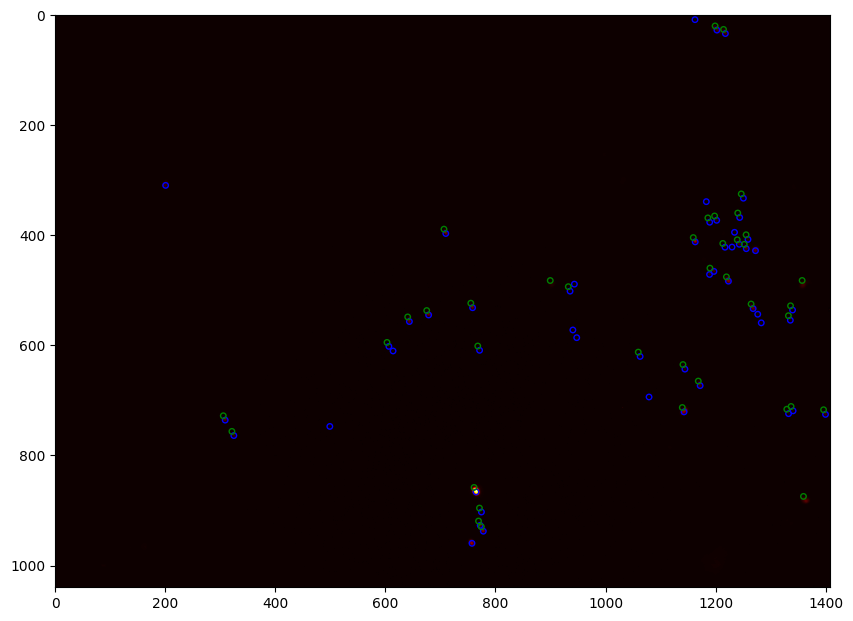

In [15]:
i = 15
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(plt.imread(tif_arr[i-1]), cmap = 'hot')
d_cord = deep_cord[i]
imaris_cord = cord_imaris[i]

for item in d_cord:
    ax.add_patch(plt.Circle((item[0],item[1]), 5, color='b',fill=False))
for item in imaris_cord:
    ax.add_patch(plt.Circle((item[0]/1.24,item[1]/1.24), 5, color='g',fill=False))


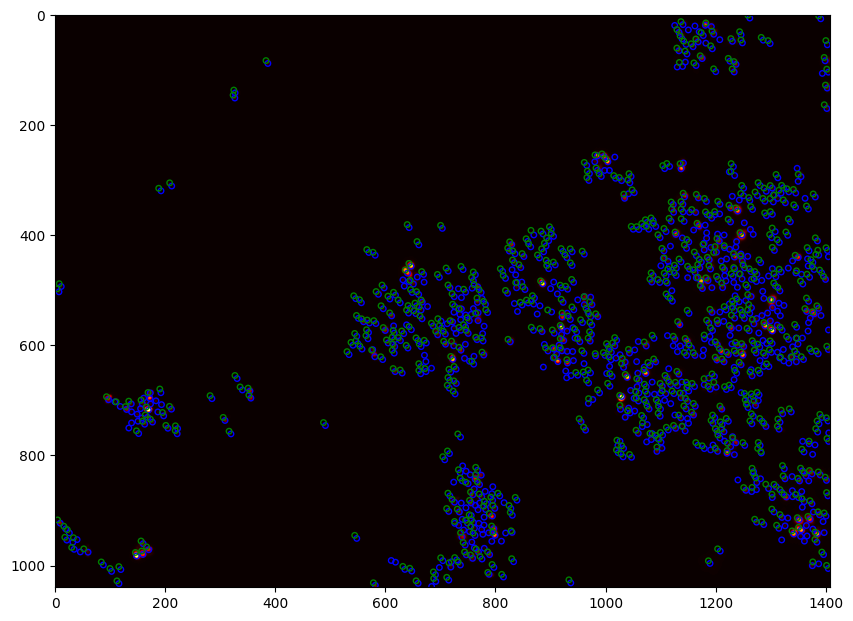

In [16]:
i = 90
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(plt.imread(tif_arr[i-1]), cmap = 'hot')
d_cord = deep_cord[i]
imaris_cord = cord_imaris[i]

for item in d_cord:
    ax.add_patch(plt.Circle((item[0],item[1]), 5, color='b',fill=False))
for item in imaris_cord:
    ax.add_patch(plt.Circle((item[0]/1.24,item[1]/1.24), 5, color='g',fill=False))


### Tracking Length Comparision

- Deep cell Tracks length are around 25 long

In [17]:
df_deep.groupby('ID').size().describe()

count    1356.000000
mean       29.106195
std        21.412979
min         1.000000
25%        11.000000
50%        24.000000
75%        46.000000
max        87.000000
dtype: float64

<AxesSubplot:>

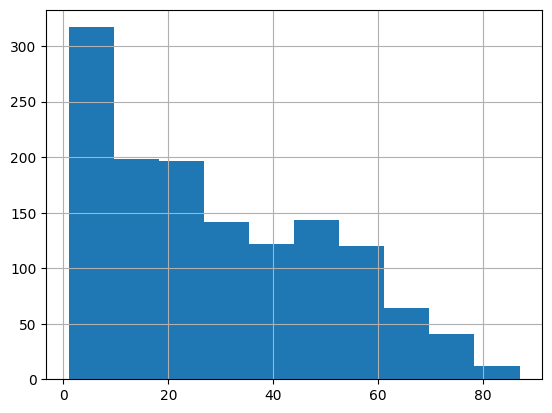

In [18]:
df_deep.groupby('ID').size().hist()

- Imaris Tracks length are around 6 long

In [19]:
df_imaris.groupby('Parent').size().describe()

count    3710.000000
mean        7.187062
std         4.895186
min         2.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        44.000000
dtype: float64

<AxesSubplot:>

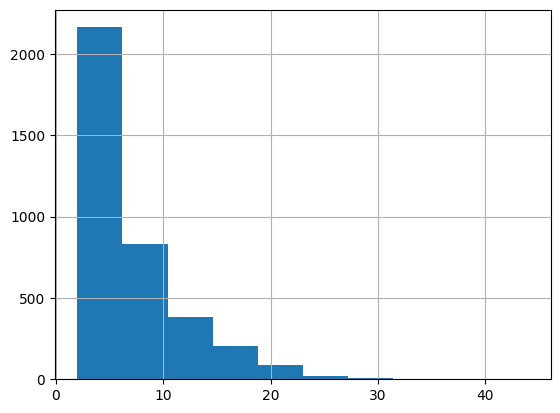

In [20]:
df_imaris.groupby('Parent').size().hist()